In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
import os
import cv2
random.seed(42)

# Mounting Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading the Dataset from Google Drive

In [4]:
dataset_path = "/content/drive/MyDrive/Animal Image Dataset(DOG, CAT and PANDA)/animals"
animals = os.listdir(dataset_path)
print(animals)

['cats', 'dogs', 'panda']



# Image Selection for Each Class
Images are selected from each class folder:
- If the class has 3000 or more images, 3000 are randomly selected.
- If less than 3000 images are available, all are selected.




In [5]:
selected_images = {}
for animal in animals:
  animal_path = os.path.join(dataset_path, animal)
  images = os.listdir(animal_path)
  if len(images) >= 3000:
    selected_images[animal] = random.sample(images, 3000)
  else:
    print(f"Class {animal} has less than 3000 images. Selecting all {len(images)} images.")
    selected_images[animal] = images

Class cats has less than 3000 images. Selecting all 1000 images.
Class dogs has less than 3000 images. Selecting all 1000 images.
Class panda has less than 3000 images. Selecting all 1000 images.



# Defining Parameters


- Images are resized to 32x32 pixels for uniformity and to reduce computational cost.
- A total of 100 images are sampled for visualization or testing.
- A list of K values from 2 to 19, typically used for evaluating
  clustering or classification performance across different K values.



In [6]:
image_size = 32
images_count = 100
k_values = list(range(2, 20))


# Image Loading and Preprocessing
Images are loaded from each class folder, converted to grayscale, resized to 32x32 pixels,
labeled with their class, and stored in a list. Finally, the list is shuffled to ensure
random distribution during training.



In [7]:
train_imgs = []

for index, animal in enumerate(animals):
    label = index
    path = os.path.join(dataset_path, animal)
    images = os.listdir(path)
    random.shuffle(images)

    for img in images[:images_count]:
        img_path = os.path.join(path, img)
        img_bgr = cv2.imread(img_path)
        img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
        img_gray = cv2.resize(img_gray, (image_size, image_size))
        train_imgs.append([img_gray, label])

np.random.shuffle(train_imgs)


# Displaying Sample Images
Displays a grid of sample grayscale images with their class labels.



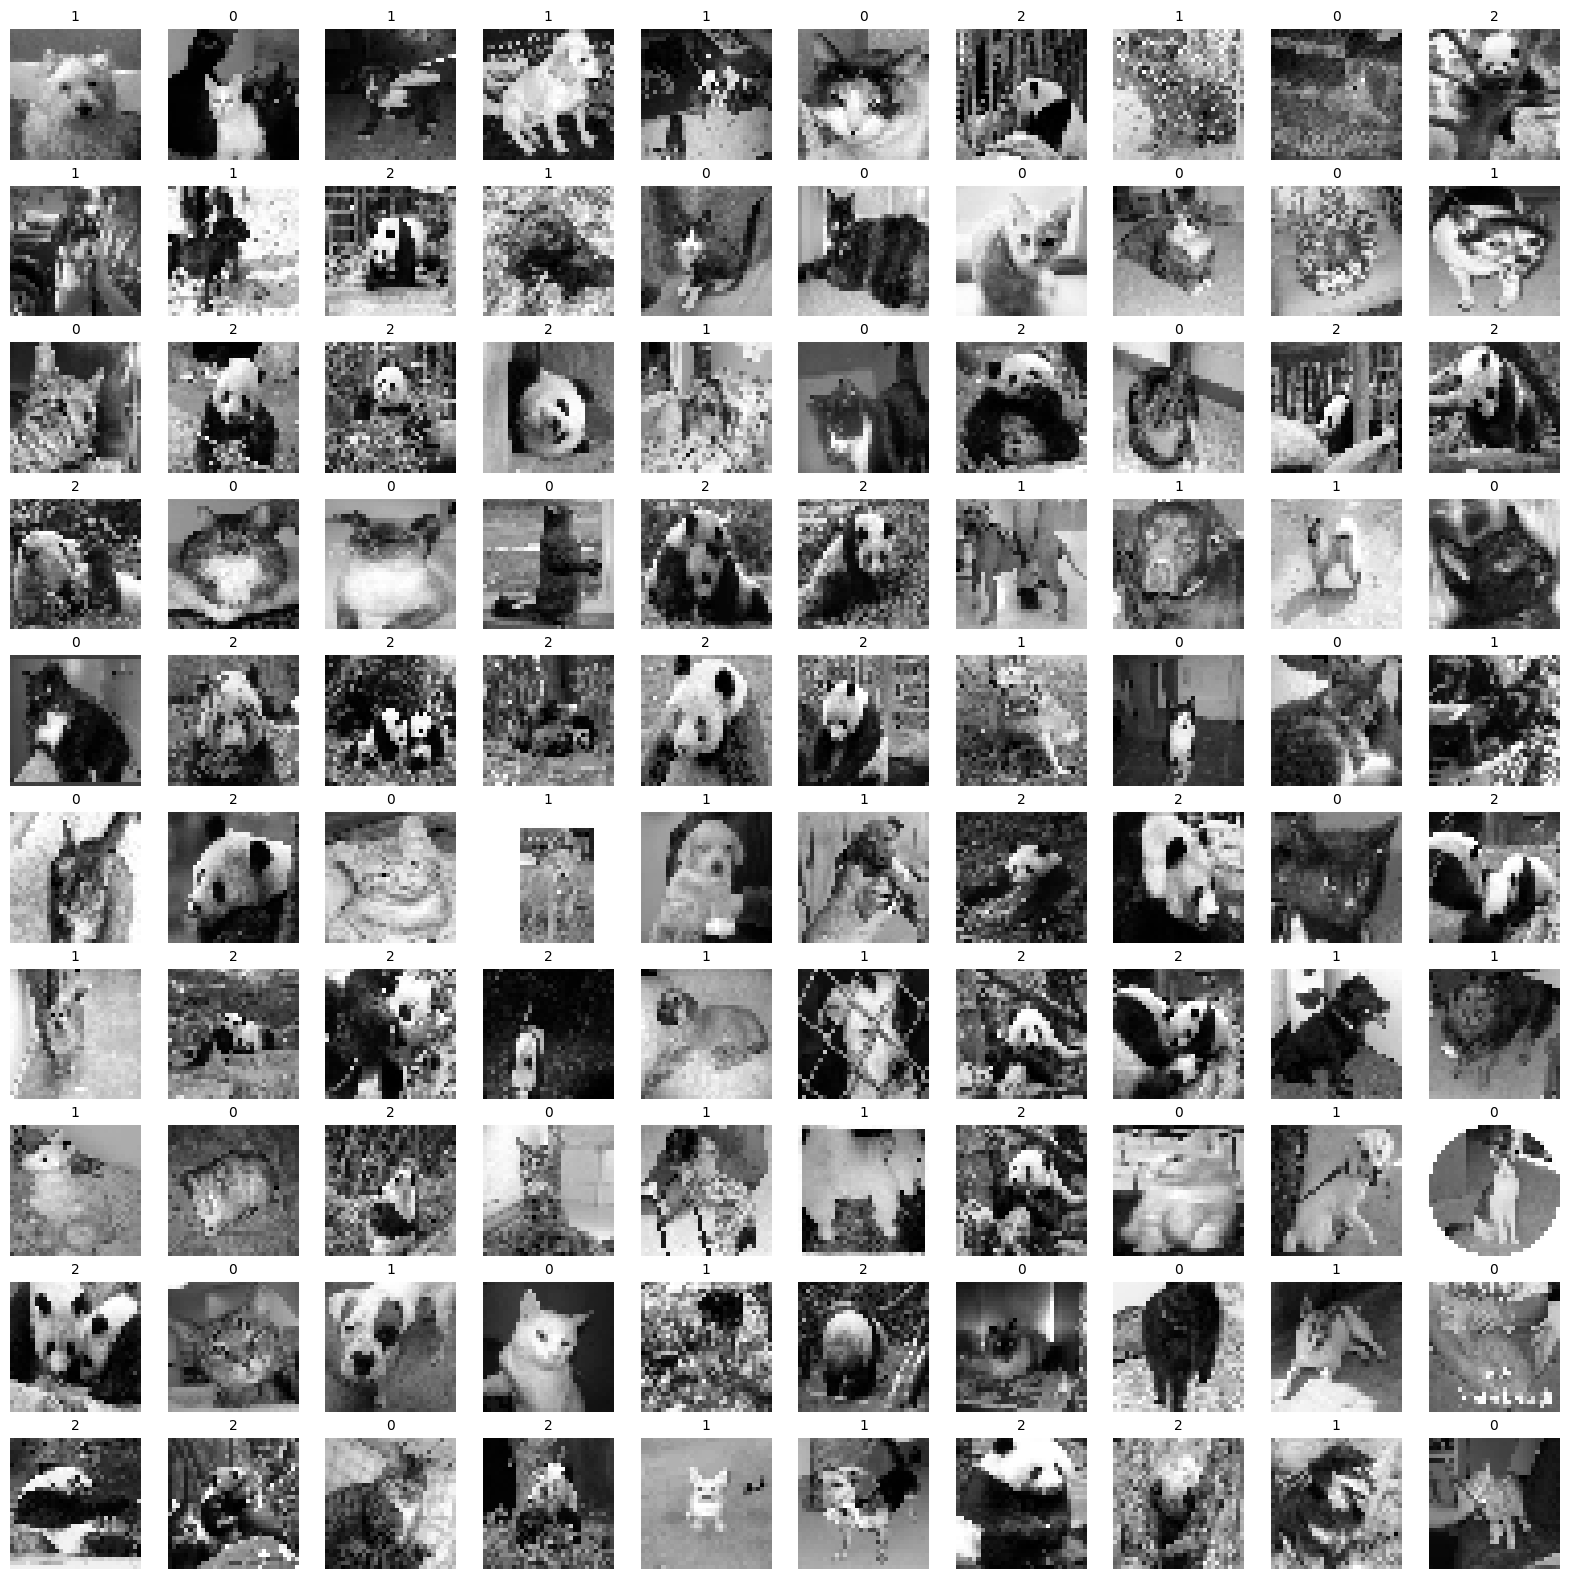

In [18]:
rows, cols = 10, 10
plt.figure(figsize=(20, 20))

for i in range(rows * cols):
    img, label = train_imgs[i]
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(label, fontsize=10)
    plt.axis('off')

plt.show()


# Defining Distance Functions
Defines functions to calculate L1 (Manhattan) and L2 (Euclidean) distances between two vectors.



In [19]:
def l1_distance(a, b):
    return np.sum(np.abs(a - b))

def l2_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

# Predict Function
Predicts the label of a test point by calculating the distances to training data points, finding the k nearest neighbors, and returning the most common label.


In [20]:
def predict(X_train, y_train, x_test, k, dist_func):
    distances = [dist_func(x_test, x) for x in X_train]
    nearest = np.argsort(distances)[:k]
    nearest_labels = y_train[nearest]
    values, counts = np.unique(nearest_labels, return_counts=True)
    return values[np.argmax(counts)]

# Cross-Validation Function
Performs k-fold cross-validation to evaluate the accuracy of the model using different k values for both L1 and L2 distance metrics.


In [21]:
def cross_validation(X, Y, k_values, folds=5):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    fold_size = len(X) // folds
    fold_indices = [indices[i*fold_size:(i+1)*fold_size] for i in range(folds)]

    accuracy_l1 = {k: [] for k in k_values}
    accuracy_l2 = {k: [] for k in k_values}

    for i in range(folds):
        val_idx = fold_indices[i]
        train_idx = np.hstack([fold_indices[j] for j in range(folds) if j != i])
        X_train, Y_train = X[train_idx], Y[train_idx]
        X_val, Y_val = X[val_idx], Y[val_idx]

        for k in k_values:
            correct_l1 = correct_l2 = 0
            for x, y_true in zip(X_val, Y_val):
                pred_l1 = predict(X_train, Y_train, x, k, l1_distance)
                pred_l2 = predict(X_train, Y_train, x, k, l2_distance)
                correct_l1 += int(pred_l1 == y_true)
                correct_l2 += int(pred_l2 == y_true)
            accuracy_l1[k].append(correct_l1 / len(Y_val))
            accuracy_l2[k].append(correct_l2 / len(Y_val))
        print(f"Fold {i+1} completed.")

    avg_l1 = {k: np.mean(accuracy_l1[k]) for k in k_values}
    avg_l2 = {k: np.mean(accuracy_l2[k]) for k in k_values}
    return avg_l1, avg_l2

# Preparing Data and Evaluating Model
Flattens the training images into vectors and performs cross-validation to calculate the average accuracy for different k values using both L1 and L2 distance metrics.


In [22]:
X = np.array([img[0].flatten() for img in train_imgs])
Y = np.array([img[1] for img in train_imgs])

avg_l1, avg_l2 = cross_validation(X, Y, k_values)

for k in k_values:
    print(f"Average Accuracy for k={k} (L1): {avg_l1[k]:.2f}")
    print(f"Average Accuracy for k={k} (L2): {avg_l2[k]:.2f}")

Fold 1 completed.
Fold 2 completed.
Fold 3 completed.
Fold 4 completed.
Fold 5 completed.
Average Accuracy for k=2 (L1): 0.36
Average Accuracy for k=2 (L2): 0.43
Average Accuracy for k=3 (L1): 0.38
Average Accuracy for k=3 (L2): 0.39
Average Accuracy for k=4 (L1): 0.41
Average Accuracy for k=4 (L2): 0.39
Average Accuracy for k=5 (L1): 0.36
Average Accuracy for k=5 (L2): 0.39
Average Accuracy for k=6 (L1): 0.40
Average Accuracy for k=6 (L2): 0.44
Average Accuracy for k=7 (L1): 0.36
Average Accuracy for k=7 (L2): 0.42
Average Accuracy for k=8 (L1): 0.38
Average Accuracy for k=8 (L2): 0.43
Average Accuracy for k=9 (L1): 0.39
Average Accuracy for k=9 (L2): 0.46
Average Accuracy for k=10 (L1): 0.41
Average Accuracy for k=10 (L2): 0.47
Average Accuracy for k=11 (L1): 0.41
Average Accuracy for k=11 (L2): 0.47
Average Accuracy for k=12 (L1): 0.40
Average Accuracy for k=12 (L2): 0.47
Average Accuracy for k=13 (L1): 0.40
Average Accuracy for k=13 (L2): 0.46
Average Accuracy for k=14 (L1): 0.39
A

# Plotting Accuracy vs. K Values
Plots the average accuracy for both L1 and L2 distance metrics against different k values to visualize performance.


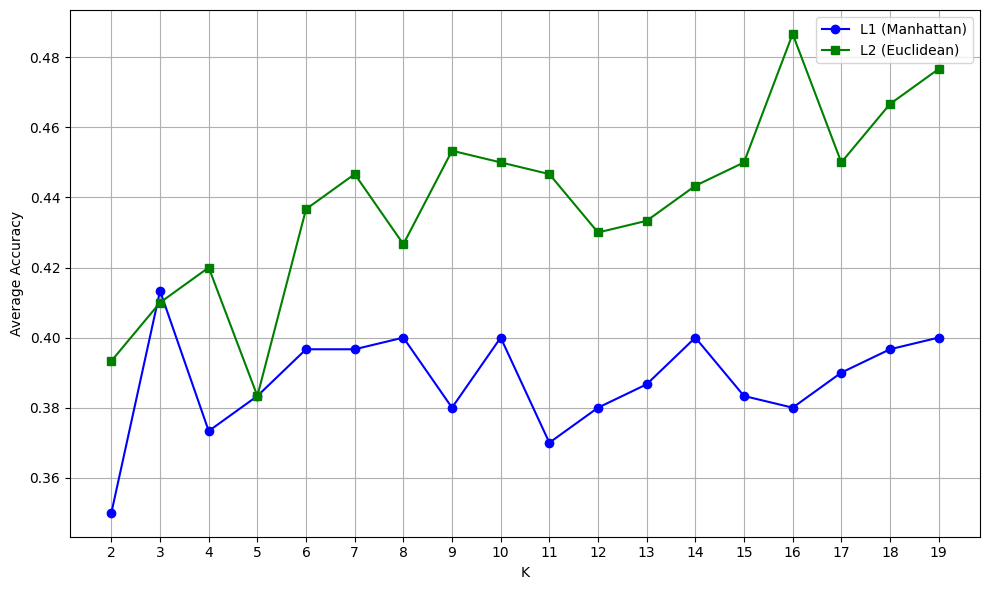

In [13]:
plt.figure(figsize=(10, 6))

plt.plot(k_values, [avg_l1[k] for k in k_values], marker='o', label='L1 (Manhattan)', color='blue')
plt.plot(k_values, [avg_l2[k] for k in k_values], marker='s', label='L2 (Euclidean)', color='green')

plt.xlabel("K")
plt.ylabel("Average Accuracy")
plt.xticks(k_values)  # Ensure integer ticks on x-axis
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Discussion of KNN Accuracy Graph

The graph shows the average classification accuracy of K-Nearest Neighbors (KNN) using different values of K.
It compares two distance metrics: L1 (Manhattan) and L2 (Euclidean).

Key Observations:

- L2 (Euclidean) consistently achieves higher accuracy than L1 (Manhattan) across almost all values of K.
- Both metrics stay in the accuracy range of about 0.35 to 0.48, but L2 reaches higher values.
- Accuracy for L1 remains stable around 0.38–0.40, while L2 improves gradually as K increases.
- The highest accuracy for L2 is at K=17 (~0.49), with a slight decrease afterward.
- L1 reaches its peak (~0.41) at K=3 and K=4, without significant gains at higher K.

Interpretation:

- Euclidean distance better captures similarity between image features in this dataset.
- Higher K values with L2 lead to better accuracy by reducing noise from individual neighbors.
- L1 shows more fluctuation and may be less effective in this high-dimensional pixel space.

Overall:

- Euclidean (L2) distance is more effective for this classification task, especially for K values 15 and above.
- There is potential to improve accuracy further by exploring feature extraction or dimensionality reduction.




# Selecting Best K Value

Finds the value of K that gives the highest average accuracy for both L1 (Manhattan) and L2 (Euclidean) distance metrics.



In [14]:
best_k_l1 = max(avg_l1, key=avg_l1.get)
best_k_l2 = max(avg_l2, key=avg_l2.get)

#Displaying the top 5 predictions


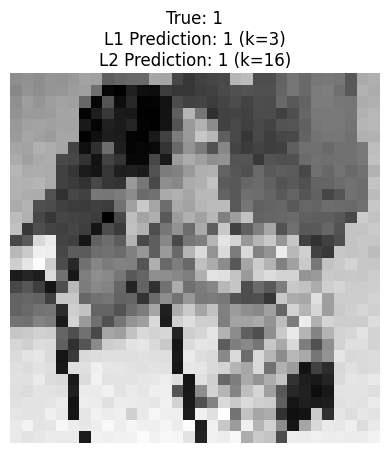

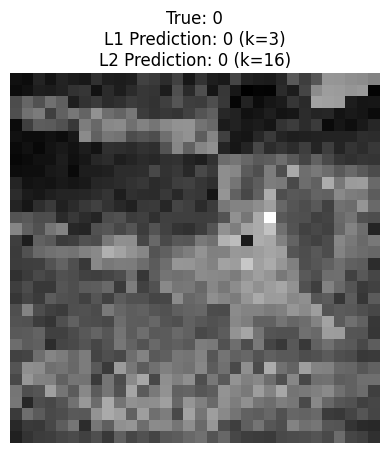

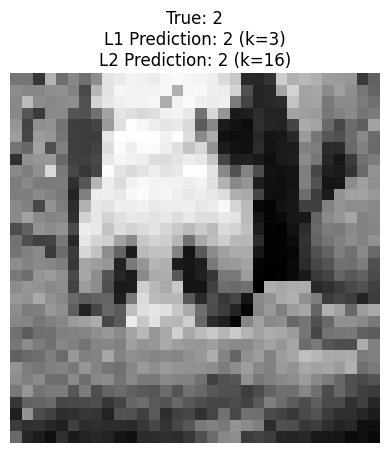

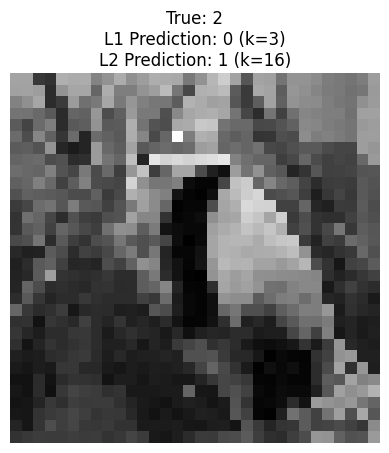

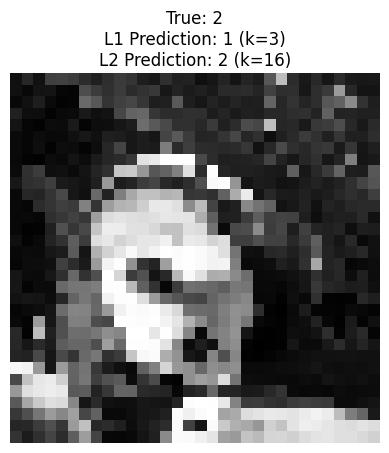

In [15]:
test_indices = random.sample(range(len(X)), 5)
X_test = X[test_indices]
Y_test = Y[test_indices]

for i, (x, true_label) in enumerate(zip(X_test, Y_test)):
    pred_l1 = predict(X, Y, x, k=best_k_l1, dist_func=l1_distance)
    pred_l2 = predict(X, Y, x, k=best_k_l2, dist_func=l2_distance)

    fig, ax = plt.subplots()
    ax.imshow(x.reshape(32, 32), cmap='gray')
    ax.axis('off')
    ax.set_title(
        f"True: {true_label}\n"
        f"L1 Prediction: {pred_l1} (k={best_k_l1})\n"
        f"L2 Prediction: {pred_l2} (k={best_k_l2})"
    )
    plt.show()